In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [2]:
os.chdir("../")
root_path = os.getcwd()

# 따옴표 안에 데이터가 있는 폴더의 상위폴더
data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

In [3]:
card = pd.read_csv(os.path.join(original_processed_file_path,'CARD_SPENDING_RESIDENT_KOR.csv'))
card['STD_DD'] = card['STD_DD'].apply(lambda x: pd.to_datetime(x,format='%Y%m%d'))

card['WEEKDAY'] = card['STD_DD'].dt.dayofweek

card['WEEK_NUM'] = card['STD_DD'].dt.weekofyear

card['MONTH_DAY'] = card['STD_DD'].astype('str').str[-5:]

# 재난지원금의 영향을 제거하기 위해 2020년 5월 5일 이전의 데이터만을 사용
ha = card[(card['MCT_CAT_CD'] == "가전") & (card['GU_CD'].str.startswith('서울')) & (card['STD_DD']<='2020-05-05')]
haha = card[(card['MCT_CAT_CD'] == "가전") & (card['GU_CD'].str.startswith('대구')) & (card['STD_DD']<='2020-05-05')]

ha['PERIOD'] = np.where(ha['STD_DD']<'2020-02-21','A - normal',np.where(ha['STD_DD']<='2020-03-15','B - spread','C - ease'))

haha['PERIOD'] = np.where(haha['STD_DD']<'2020-02-21','A - normal',np.where(haha['STD_DD']<='2020-03-15','B - spread','C - ease'))

# 나이대 별 분석

## 코로나 진행 시기 소비횟수 / 소비금액 합산

Text(0.5, 1.0, '연령대의 시기별 소비금액(대구)')

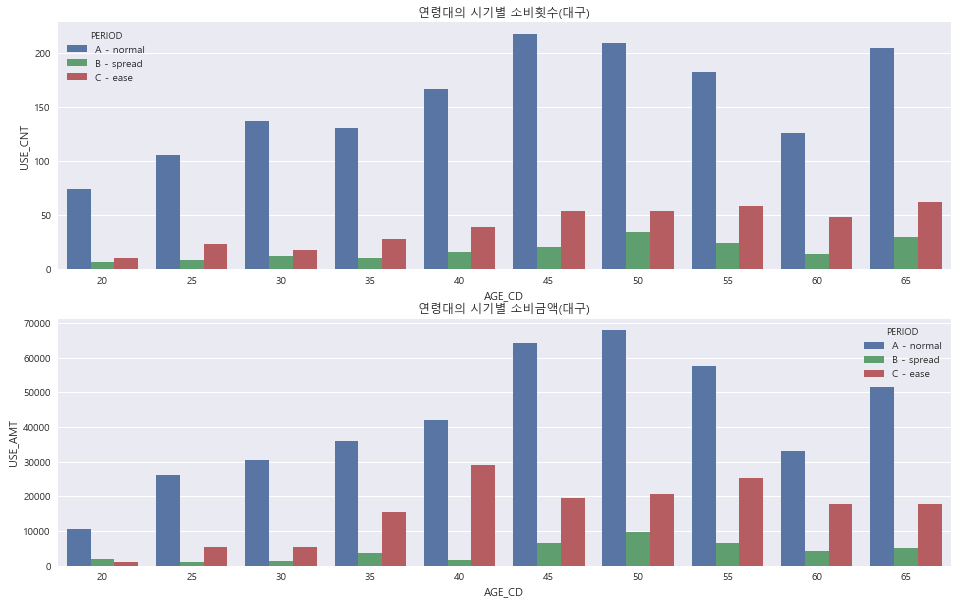

In [20]:
# YEAR, MONTH로 묶고 AMT, CNT 합 구하기(대구)
category_df = haha.groupby(['PERIOD','AGE_CD','DONG_CD'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
category_df = category_df.groupby(['PERIOD','AGE_CD'])[['USE_AMT', 'USE_CNT']].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
sns.barplot(x=category_df['AGE_CD'], y=category_df['USE_CNT'], hue='PERIOD', data=category_df, ax=axes[0])
sns.barplot(x=category_df['AGE_CD'], y=category_df['USE_AMT'], hue='PERIOD', data=category_df, ax=axes[1])
axes[0].set_title("연령대의 시기별 소비횟수(대구)")
axes[1].set_title("연령대의 시기별 소비금액(대구)")

서울과 대구 모두 코로나 진행 상황에 따라 비슷한 양상을 보이고 있다. => 코로나 이전 > 완화 > 확산

## 요일별 코로나 시기 소비횟수/소비금액

In [13]:
def period_weekday_hue_age_seoul(how_col):
    category_df = ha.groupby(['PERIOD','AGE_CD','DONG_CD','WEEKDAY'])[[how_col]].mean().reset_index()
    category_df = category_df.groupby(['PERIOD','AGE_CD','WEEKDAY'])[[how_col]].sum().reset_index()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))
    sns.barplot(x=category_df.query('PERIOD == "A - normal"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[0])
    sns.barplot(x=category_df.query('PERIOD == "B - spread"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[1])
    sns.barplot(x=category_df.query('PERIOD == "C - ease"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[2])
    axes[0].set_title("코로나 이전 시기 연령대의 요일별 {}(서울)".format(how_col))
    axes[1].set_title("코로나 확산 시기 연령대의 요일별 {}(서울)".format(how_col))
    axes[2].set_title("코로나 완화 시기 연령대의 요일별 {}(서울)".format(how_col))
    
def period_weekday_hue_age_daegu(how_col):
    category_df = haha.groupby(['PERIOD','AGE_CD','DONG_CD','WEEKDAY'])[[how_col]].mean().reset_index()
    category_df = category_df.groupby(['PERIOD','AGE_CD','WEEKDAY'])[[how_col]].sum().reset_index()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))
    sns.barplot(x=category_df.query('PERIOD == "A - normal"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[0])
    sns.barplot(x=category_df.query('PERIOD == "B - spread"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[1])
    sns.barplot(x=category_df.query('PERIOD == "C - ease"')['AGE_CD'], y=category_df[how_col], hue='WEEKDAY', data=category_df, ax=axes[2])
    axes[0].set_title("코로나 이전 시기 연령대의 요일별 {}(대구)".format(how_col))
    axes[1].set_title("코로나 확산 시기 연령대의 요일별 {}(대구)".format(how_col))
    axes[2].set_title("코로나 완화 시기 연령대의 요일별 {}(대구)".format(how_col))

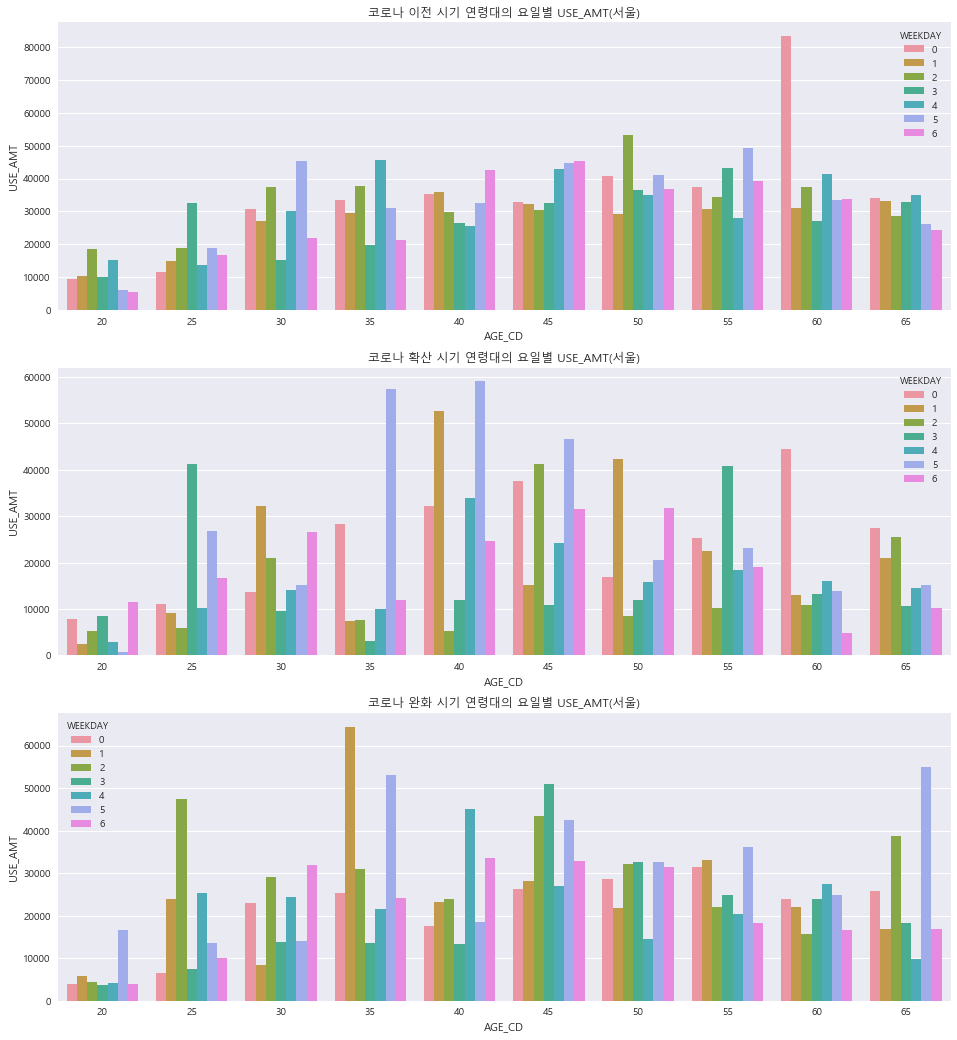

In [14]:
# USE_AMT
period_weekday_hue_age_seoul('USE_AMT')

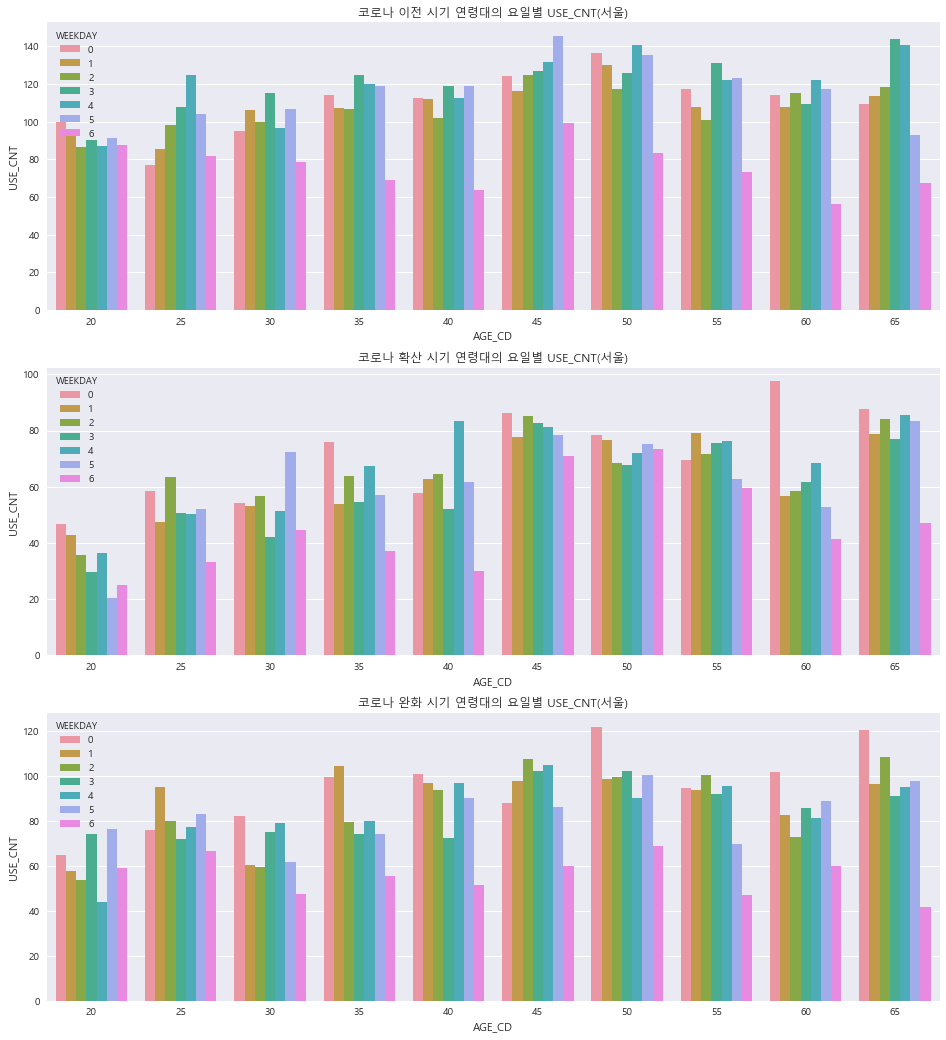

In [15]:
# USE_CNT
period_weekday_hue_age_seoul('USE_CNT')

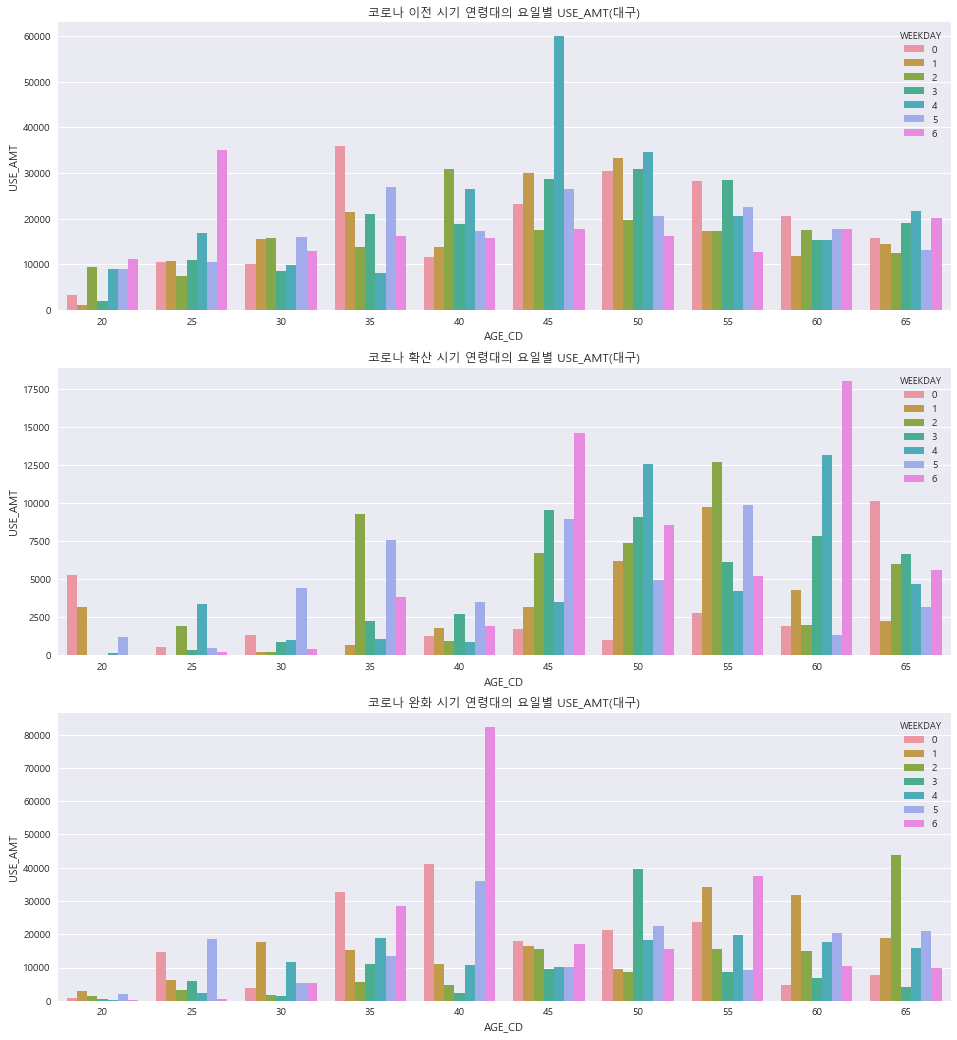

In [18]:
# USE_AMT
period_weekday_hue_age_daegu('USE_AMT')

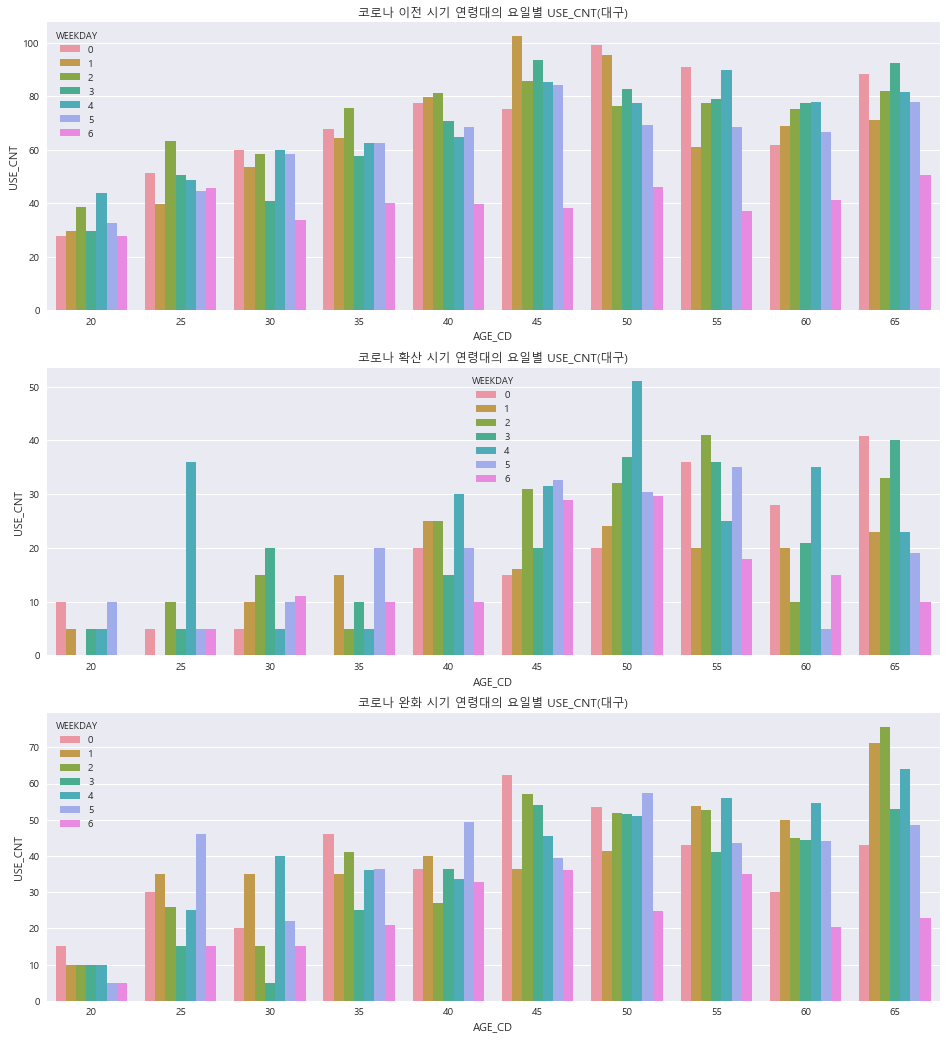

In [19]:
# USE_CNT
period_weekday_hue_age_daegu('USE_CNT')

서울은 코로나 진행 상황에 따라 완화 기간에는 이전 수준으로 회복하려는 데 비해, 대구는 코로나 완화 기간에도 서울에 비해서는 회복이 더디다.<br>
또한 대구는 확산 시기에 소비 금액이 압도적으로 감소했다.

# 성별 분석

## 코로나 진행 시기 소비횟수 / 소비금액 합산

Text(0.5, 1.0, '성별의 시기별 소비금액(대구)')

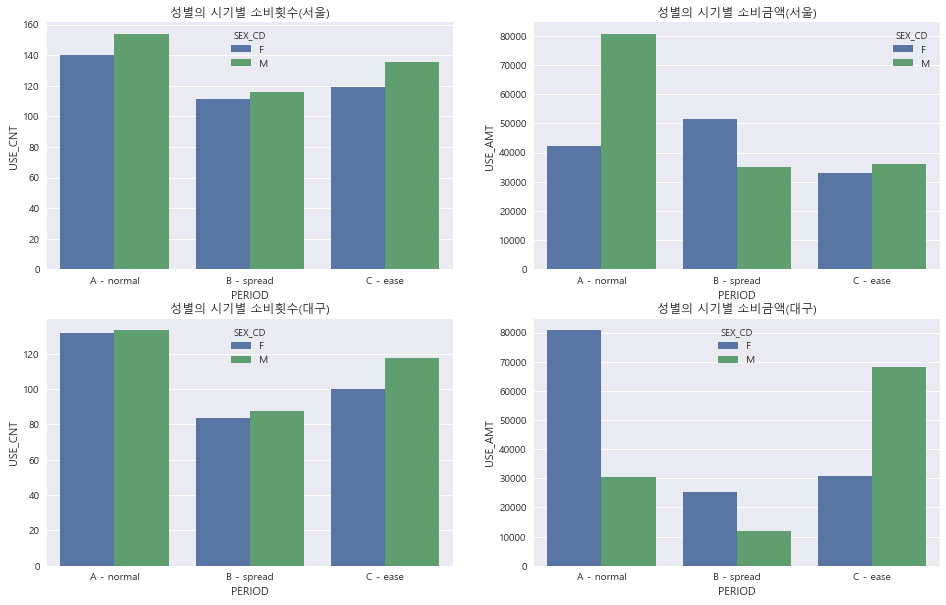

In [47]:
# YEAR, MONTH로 묶고 AMT, CNT 합 구하기
category_df1 = ha.groupby(['PERIOD','SEX_CD','DONG_CD'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
category_df1 = category_df1.groupby(['PERIOD','SEX_CD'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
category_df2 = haha.groupby(['PERIOD','SEX_CD','DONG_CD'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
category_df2 = category_df2.groupby(['PERIOD','SEX_CD'])[['USE_AMT', 'USE_CNT']].sum().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
sns.barplot(x=category_df1['PERIOD'], y=category_df1['USE_CNT'], hue='SEX_CD', data=category_df1, ax=axes[0,0])
sns.barplot(x=category_df1['PERIOD'], y=category_df1['USE_AMT'], hue='SEX_CD', data=category_df1, ax=axes[0,1])
sns.barplot(x=category_df2['PERIOD'], y=category_df2['USE_CNT'], hue='SEX_CD', data=category_df2, ax=axes[1,0])
sns.barplot(x=category_df2['PERIOD'], y=category_df2['USE_AMT'], hue='SEX_CD', data=category_df2, ax=axes[1,1])
axes[0,0].set_title("성별의 시기별 소비횟수(서울)")
axes[0,1].set_title("성별의 시기별 소비금액(서울)")
axes[1,0].set_title("성별의 시기별 소비횟수(대구)")
axes[1,1].set_title("성별의 시기별 소비금액(대구)")

## 요일별 코로나 시기 소비횟수 / 소비금액

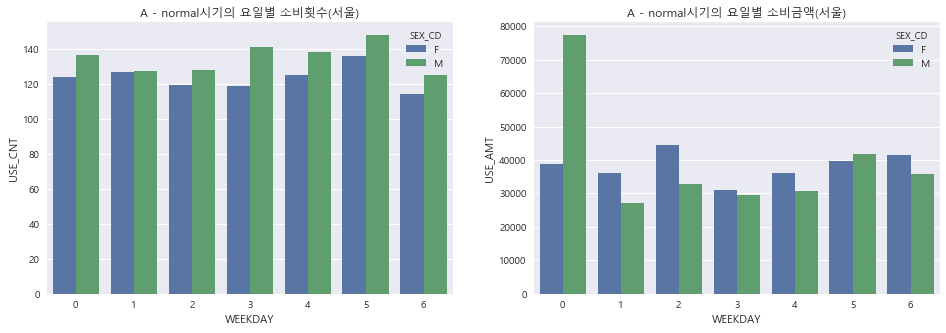

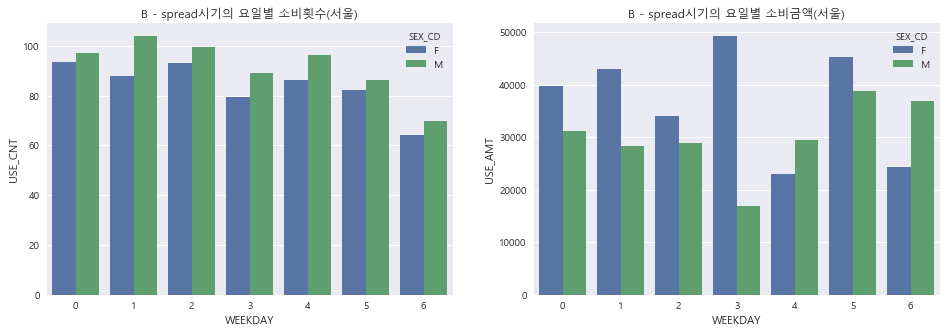

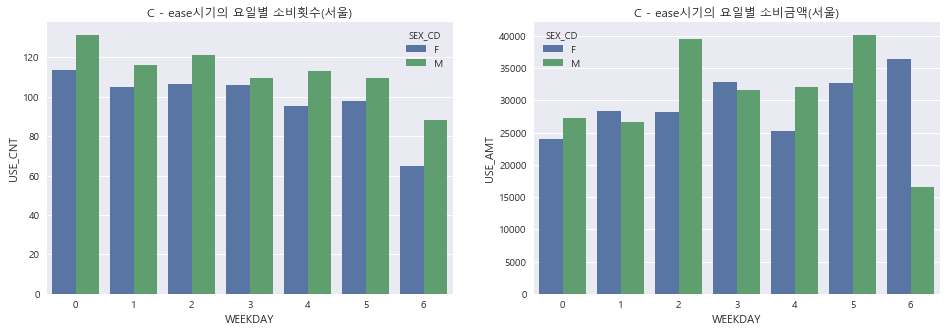

In [54]:
for peri in ha['PERIOD'].unique():
    category_df1 = ha[ha['PERIOD'].str.contains("{}".format(peri))].groupby(['SEX_CD','DONG_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
    category_df1 = category_df1.groupby(['SEX_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].sum().reset_index()

    fig, axes = plt.subplots( ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_CNT'], hue='SEX_CD', data=category_df1, ax=axes[0])
    sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_AMT'], hue='SEX_CD', data=category_df1, ax=axes[1])

    axes[0].set_title(peri + "시기의 요일별 소비횟수(서울)")
    axes[1].set_title(peri + "시기의 요일별 소비금액(서울)")

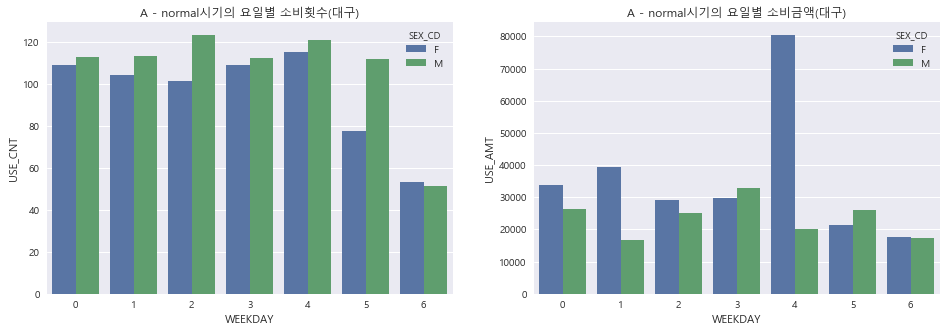

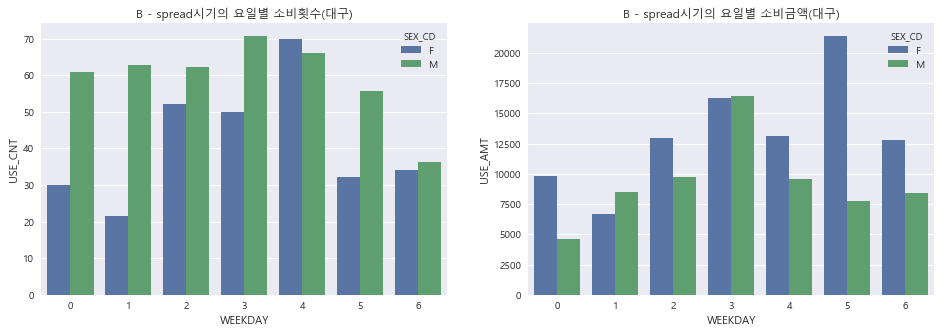

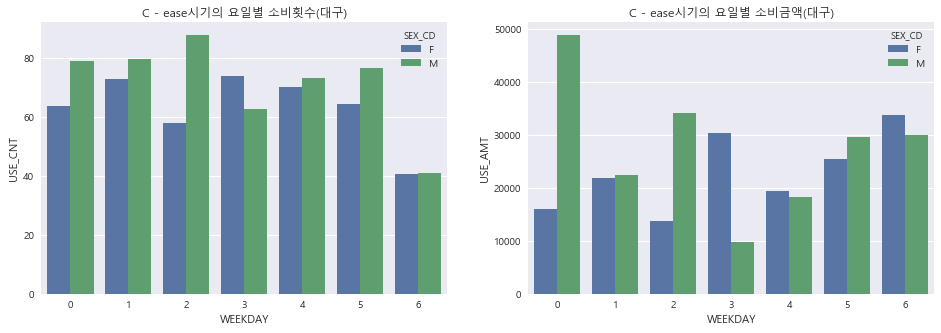

In [55]:
for peri in haha['PERIOD'].unique():
    category_df1 = haha[haha['PERIOD'].str.contains("{}".format(peri))].groupby(['SEX_CD','DONG_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
    category_df1 = category_df1.groupby(['SEX_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].sum().reset_index()

    fig, axes = plt.subplots( ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_CNT'], hue='SEX_CD', data=category_df1, ax=axes[0])
    sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_AMT'], hue='SEX_CD', data=category_df1, ax=axes[1])

    axes[0].set_title(peri + "시기의 요일별 소비횟수(대구)")
    axes[1].set_title(peri + "시기의 요일별 소비금액(대구)")

## 연령별 코로나 시기 요일 소비횟수 / 소비금액

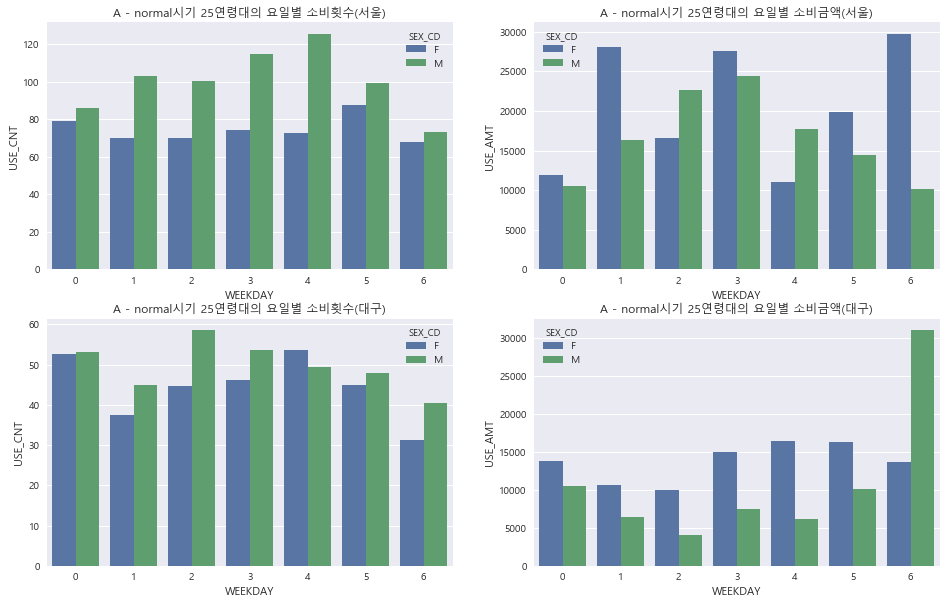

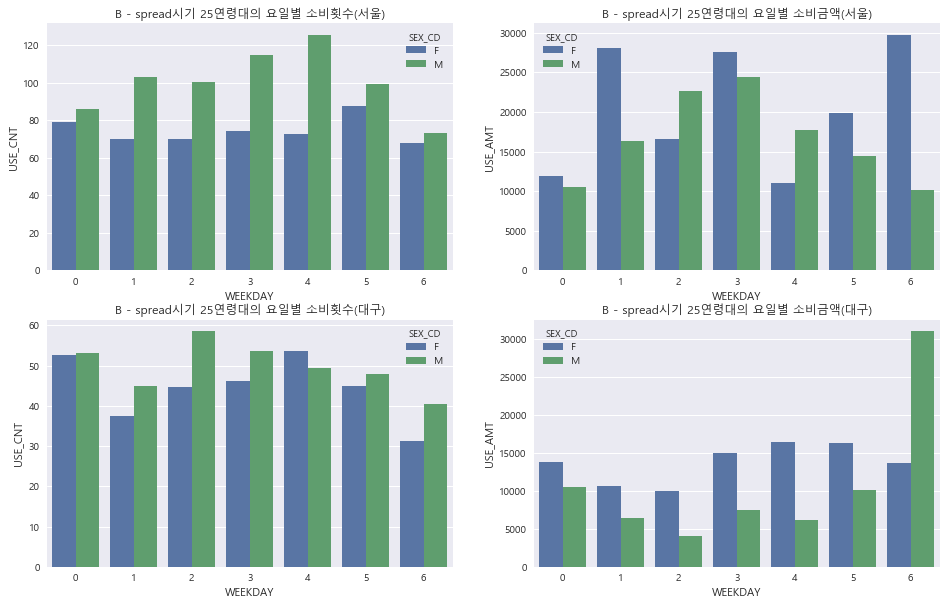

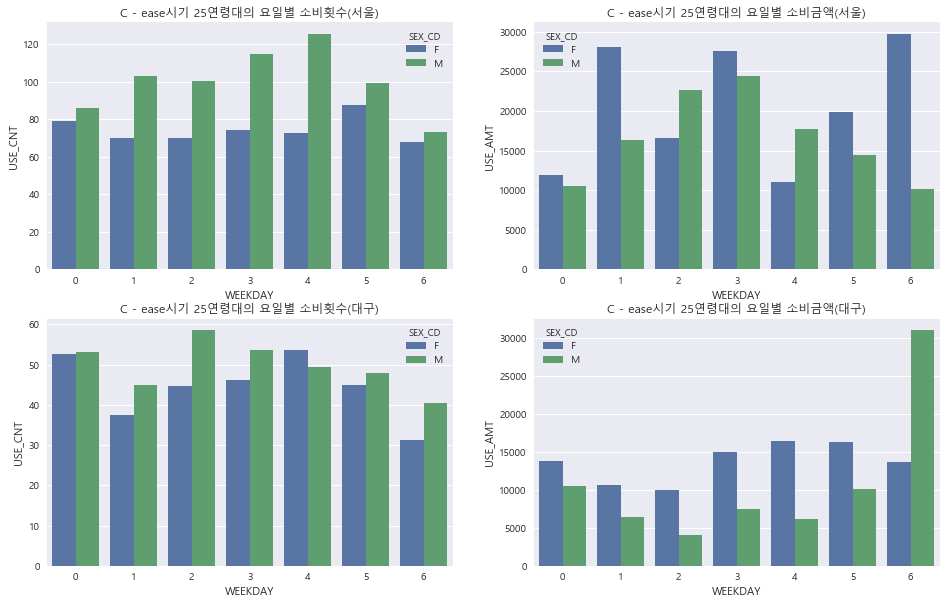

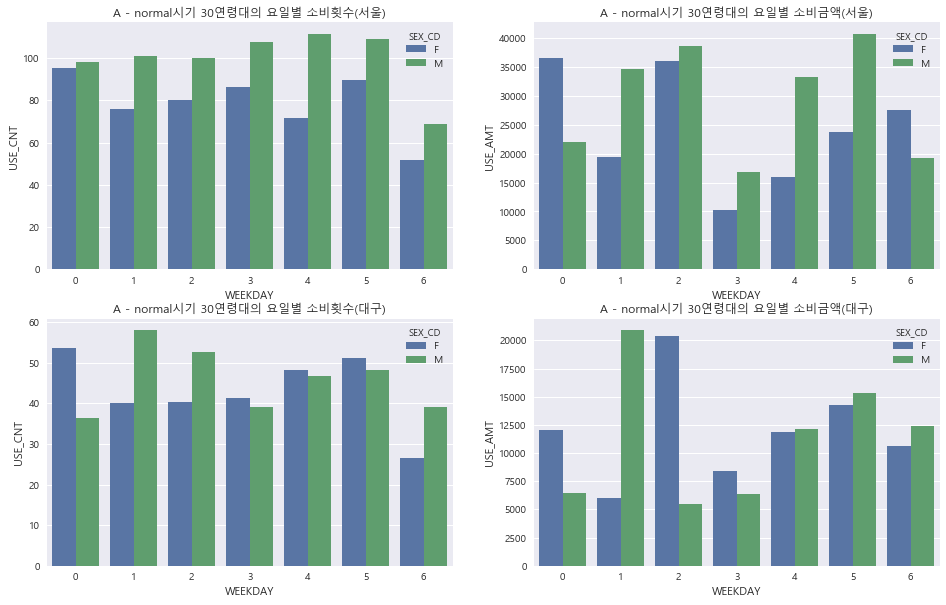

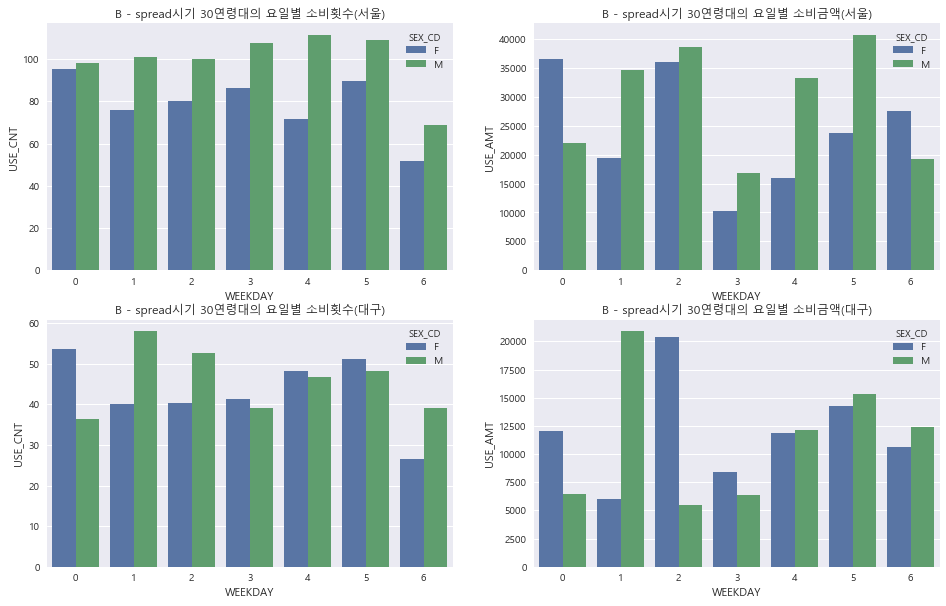

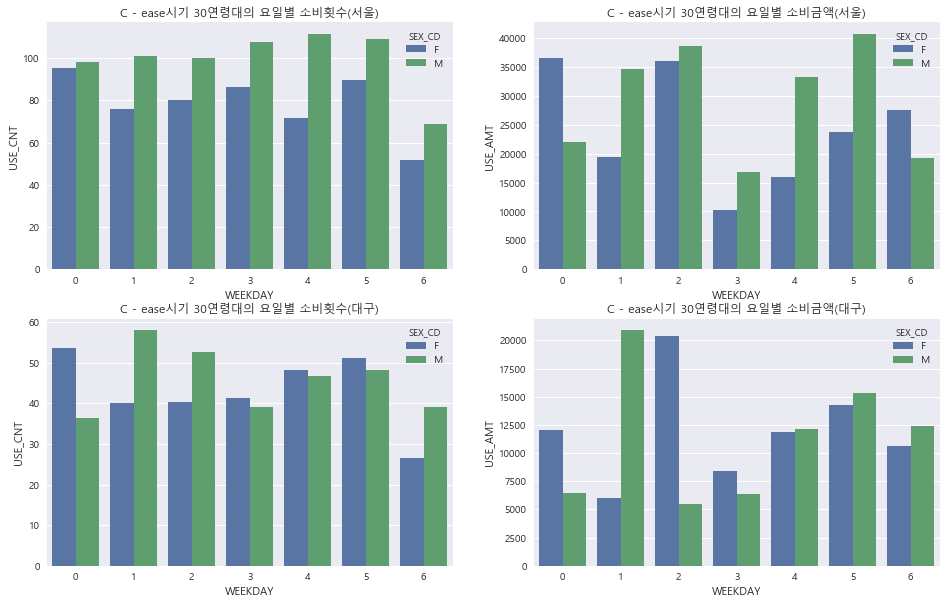

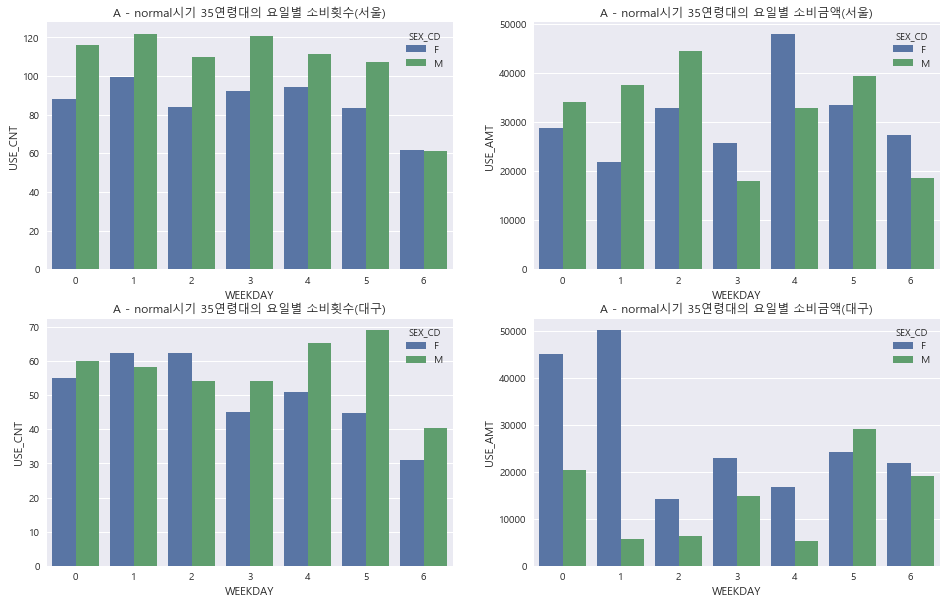

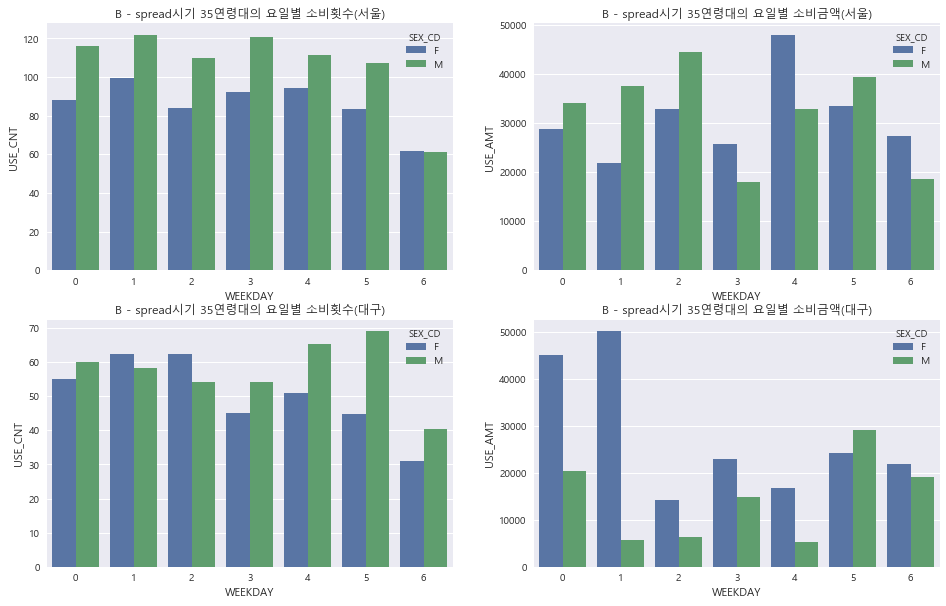

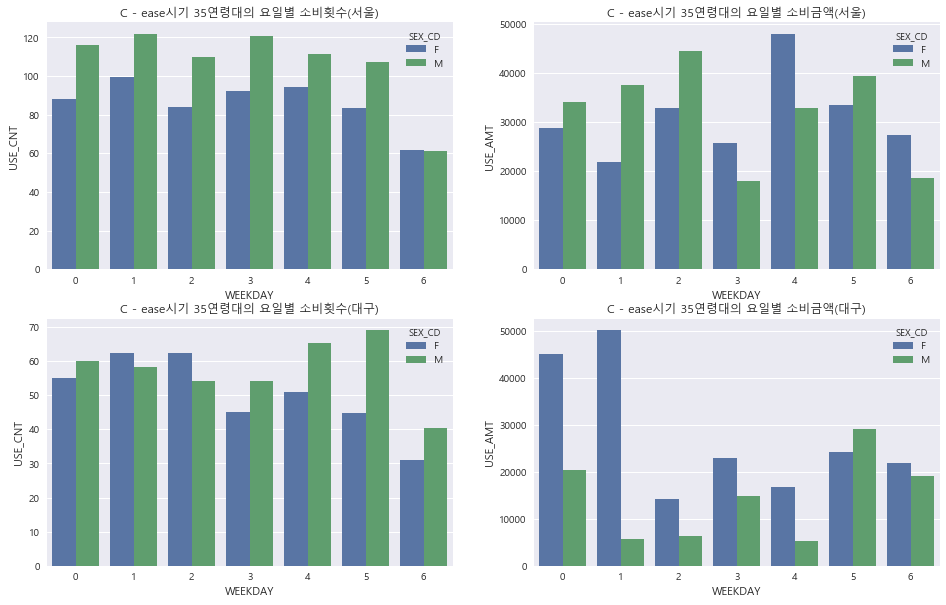

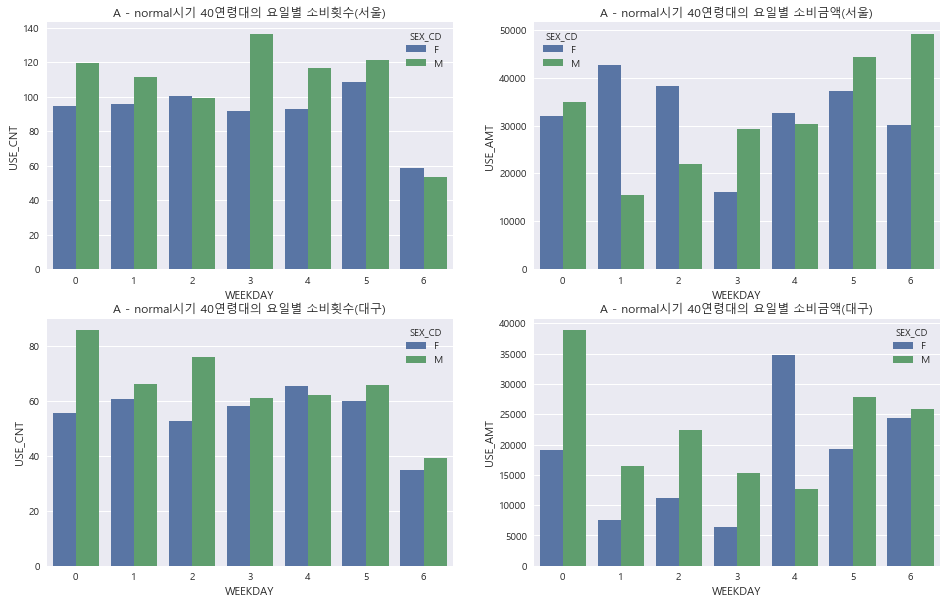

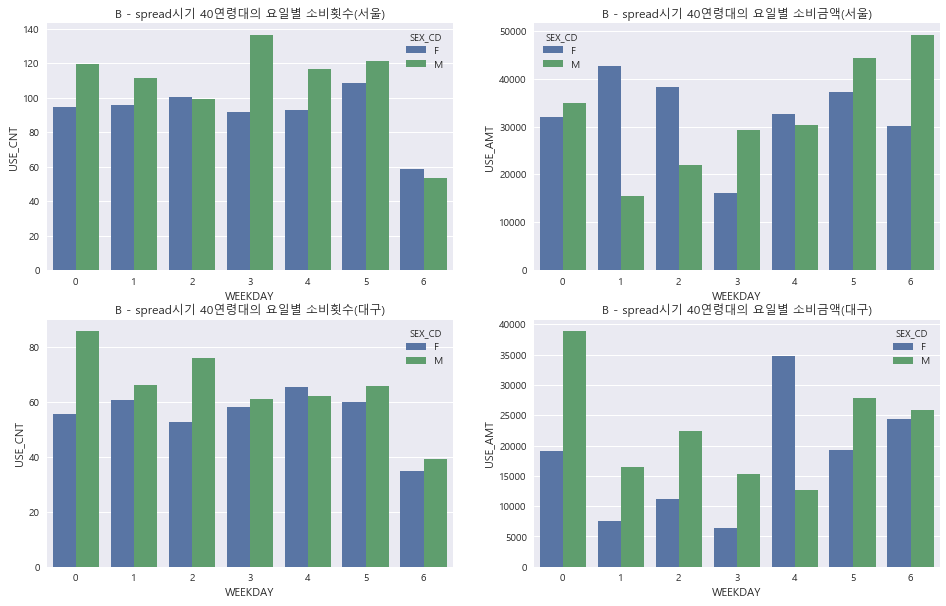

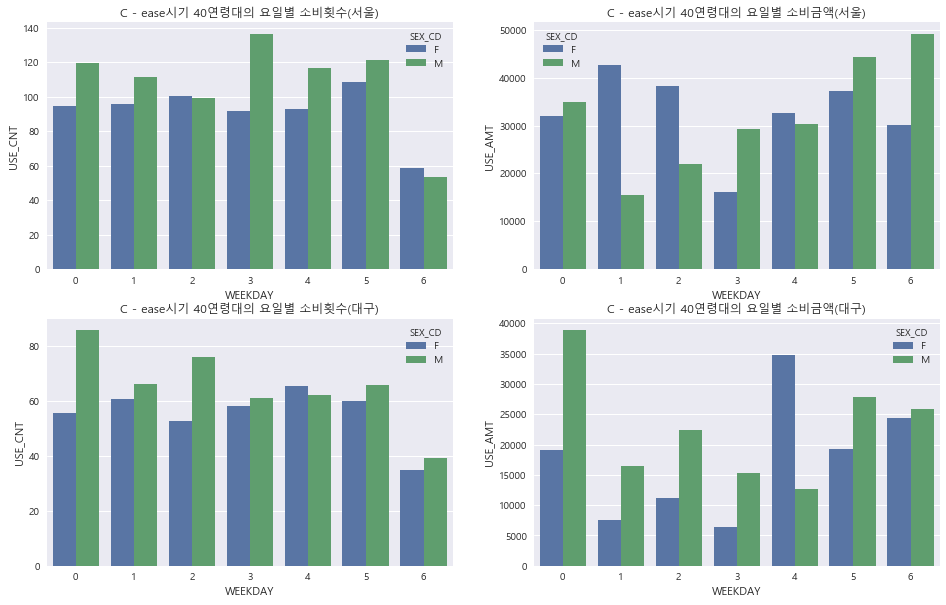

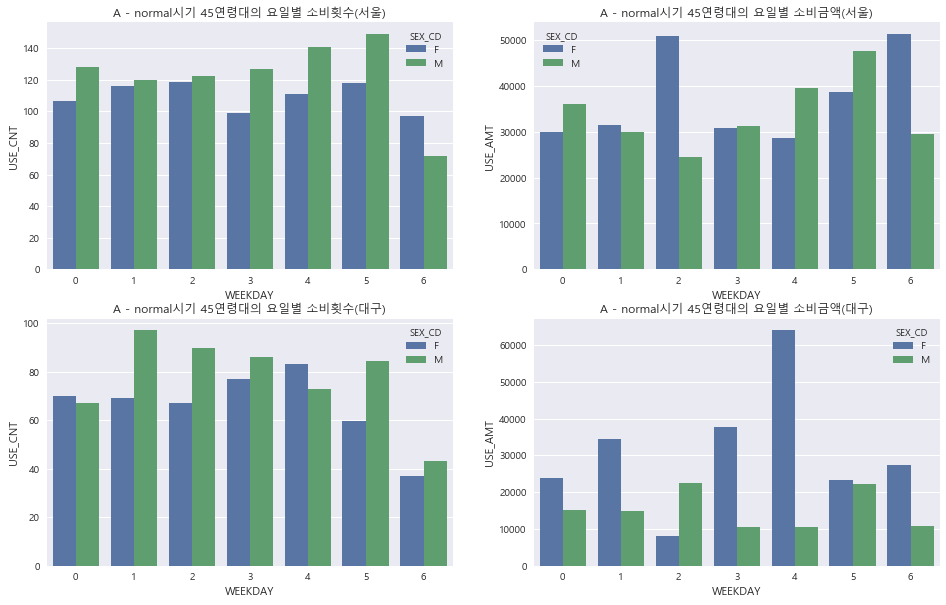

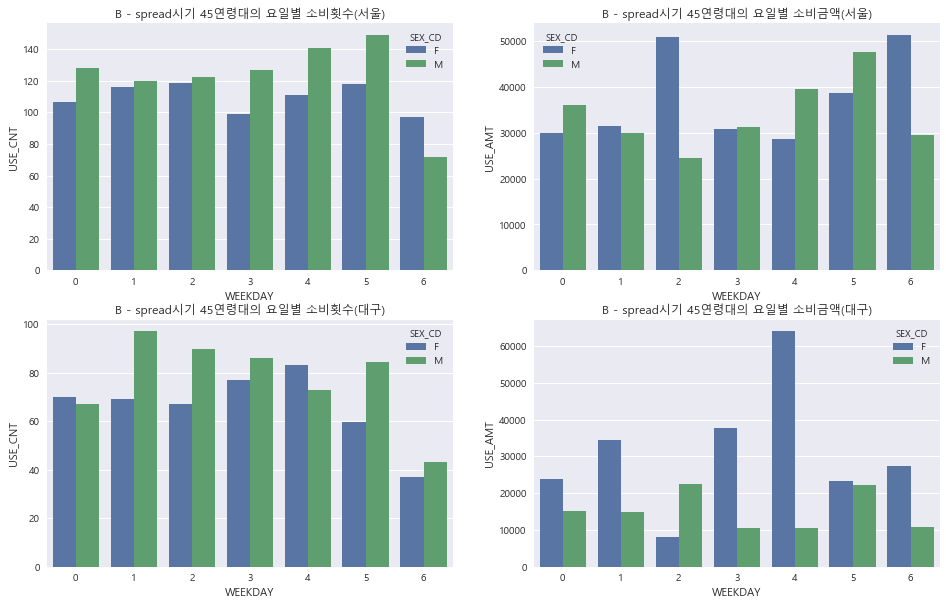

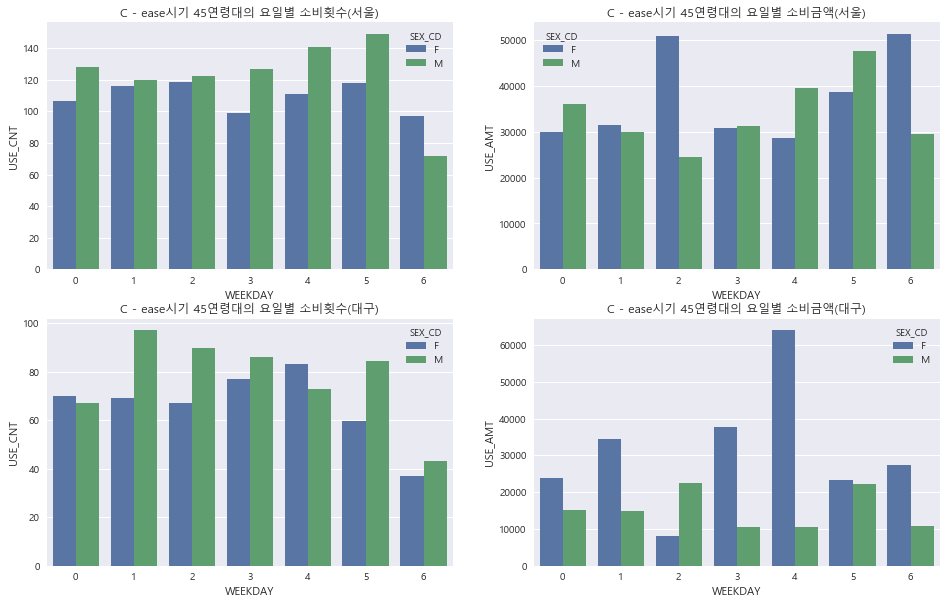

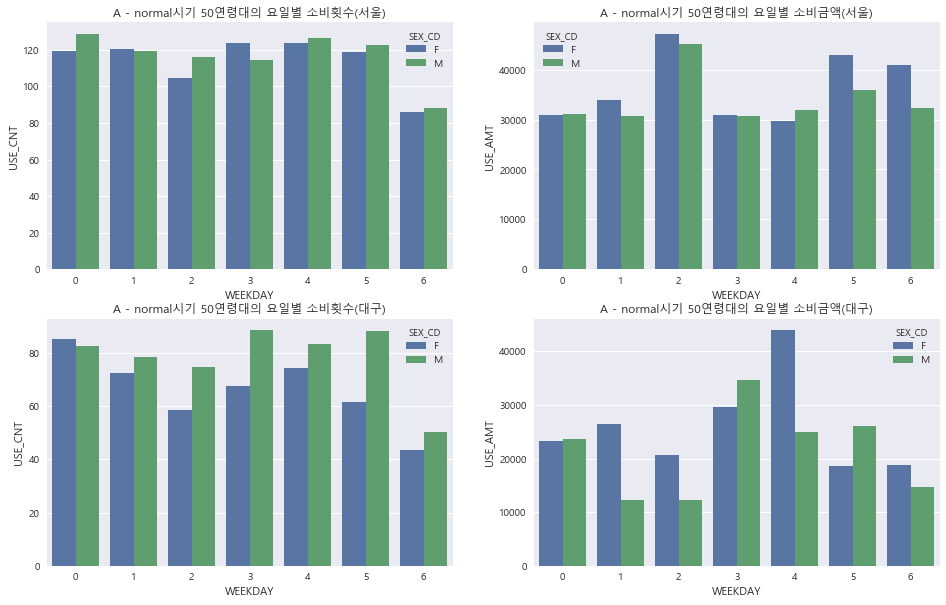

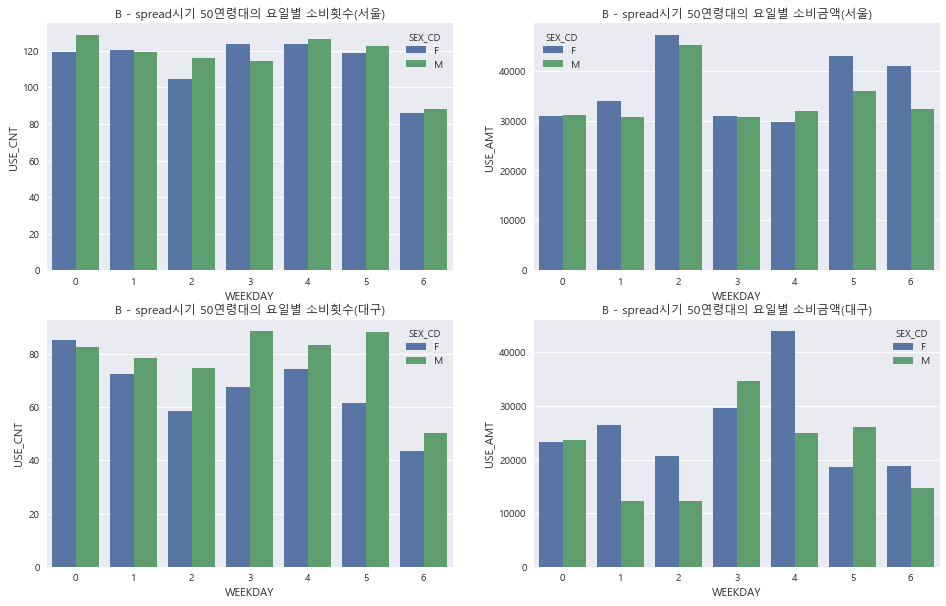

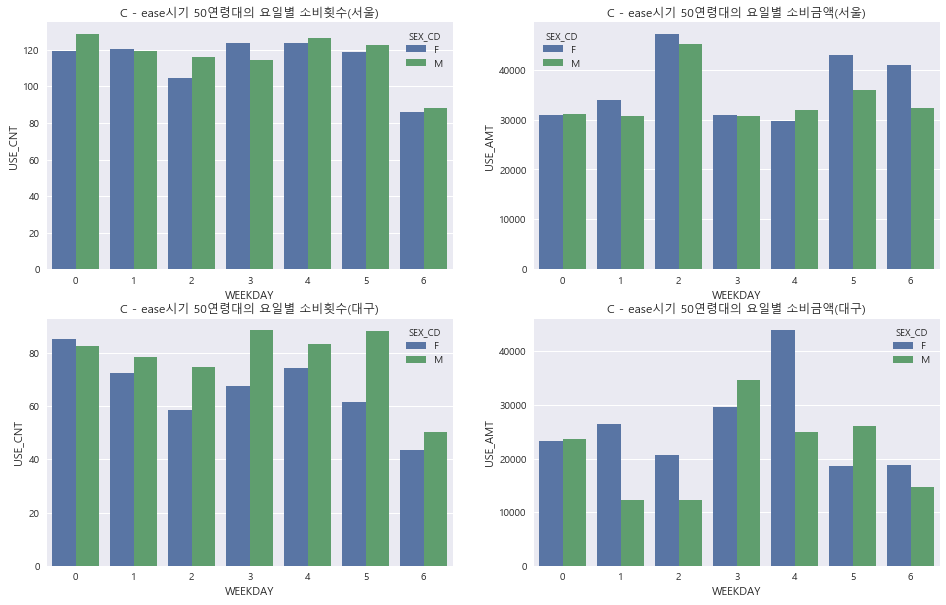

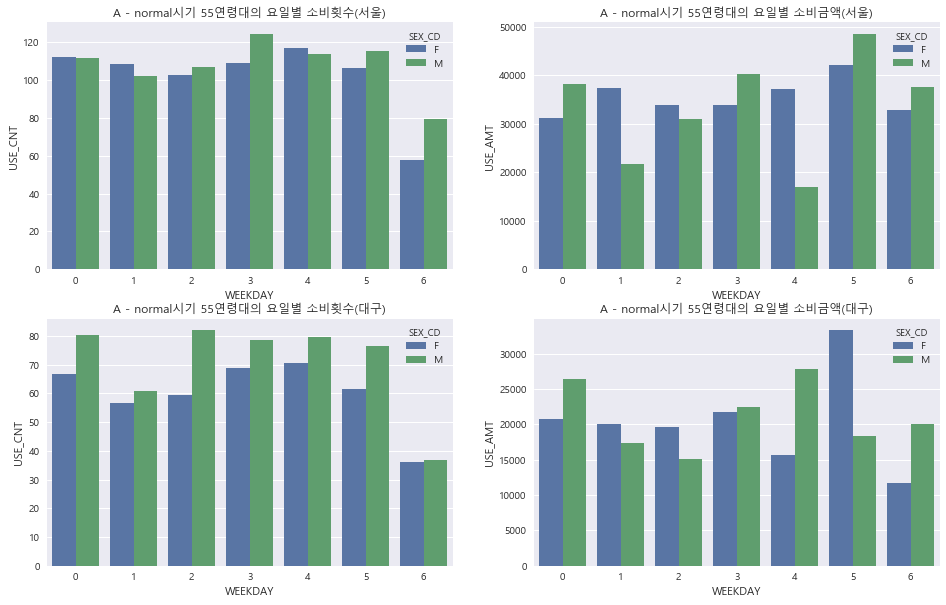

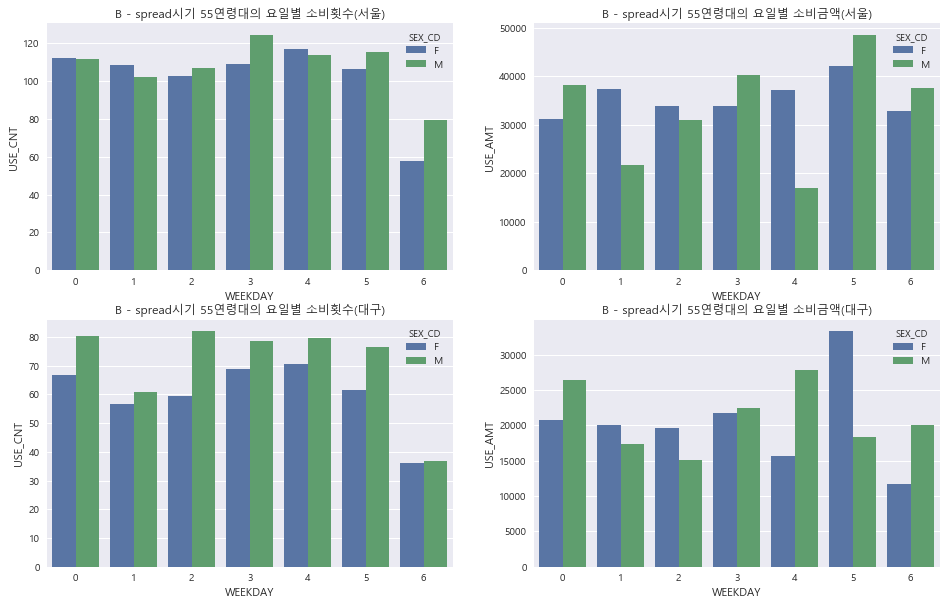

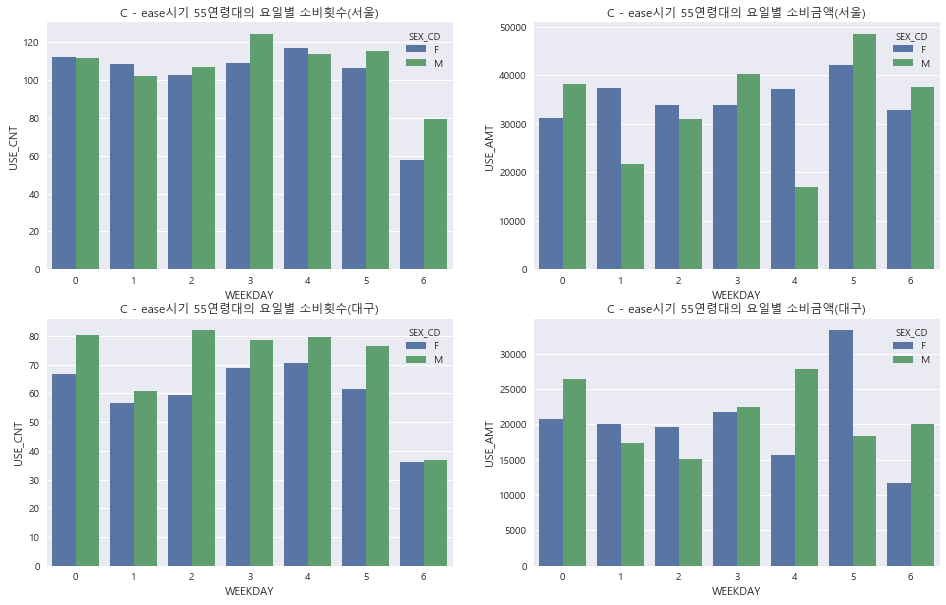

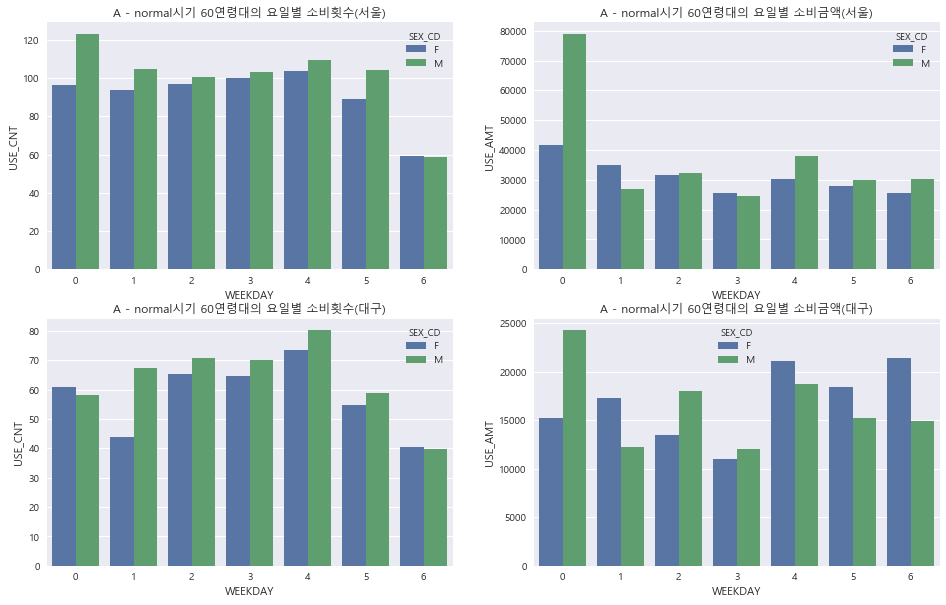

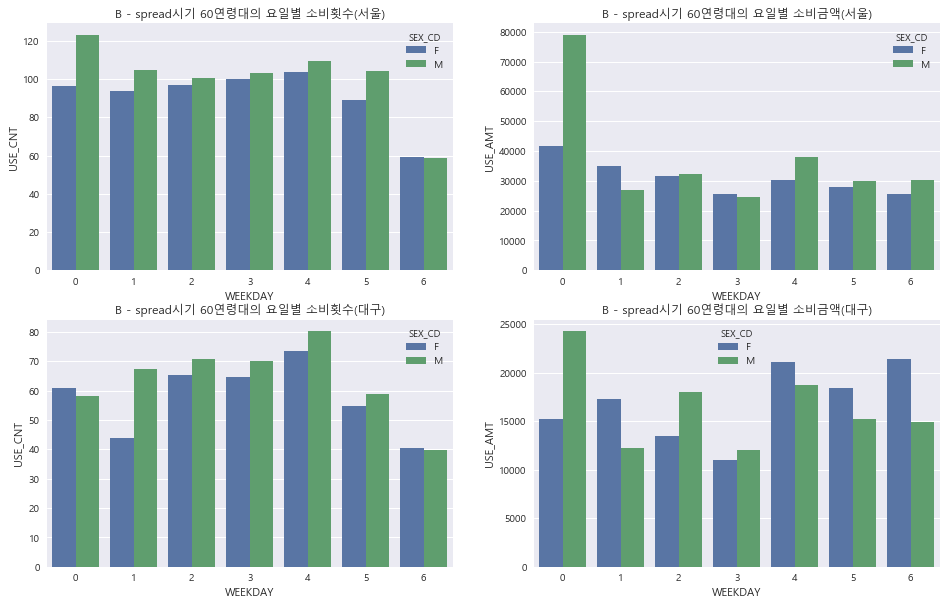

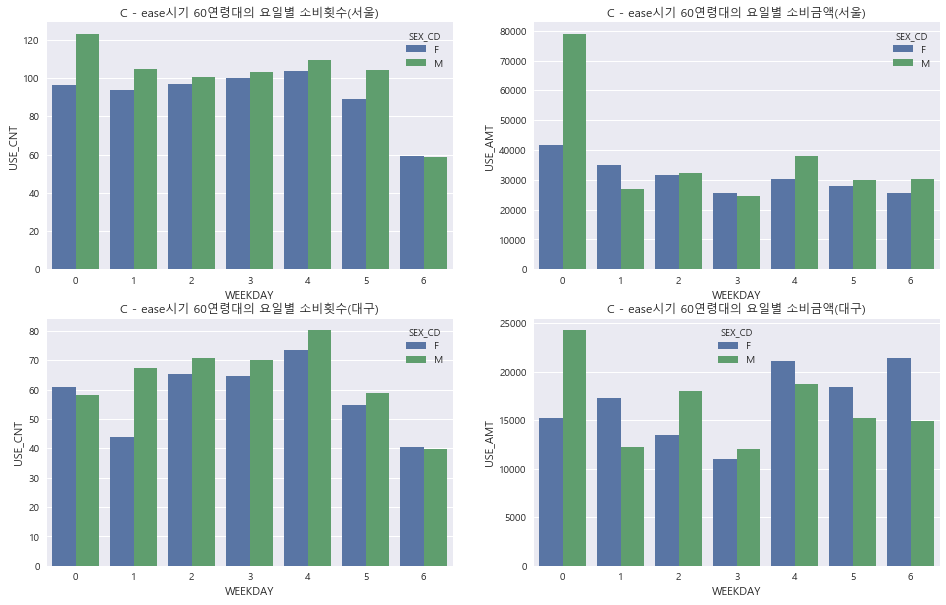

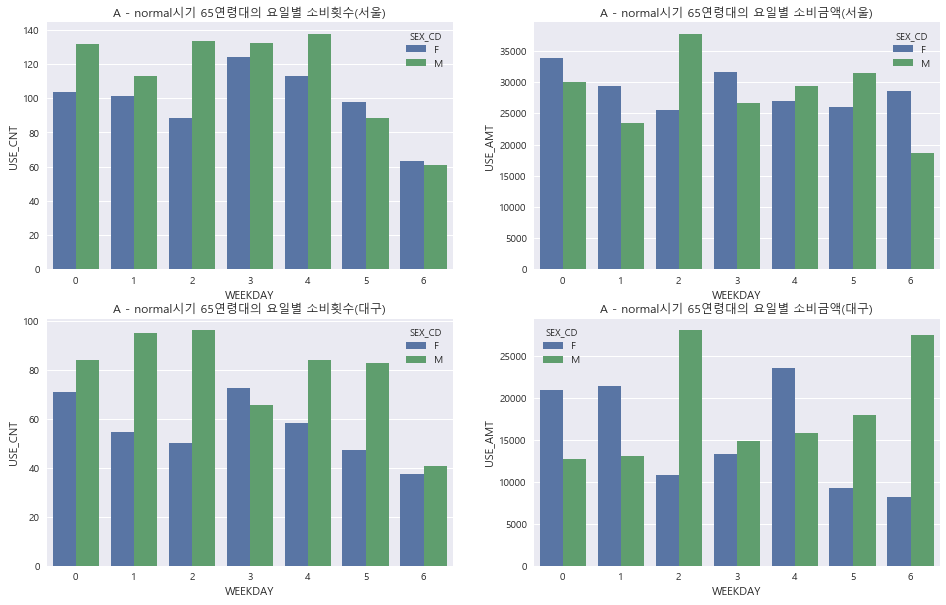

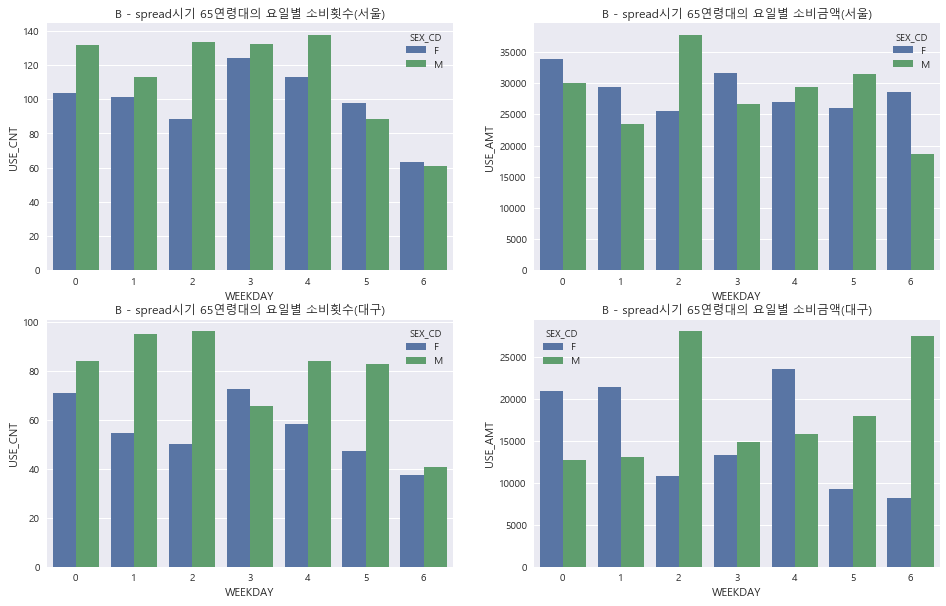

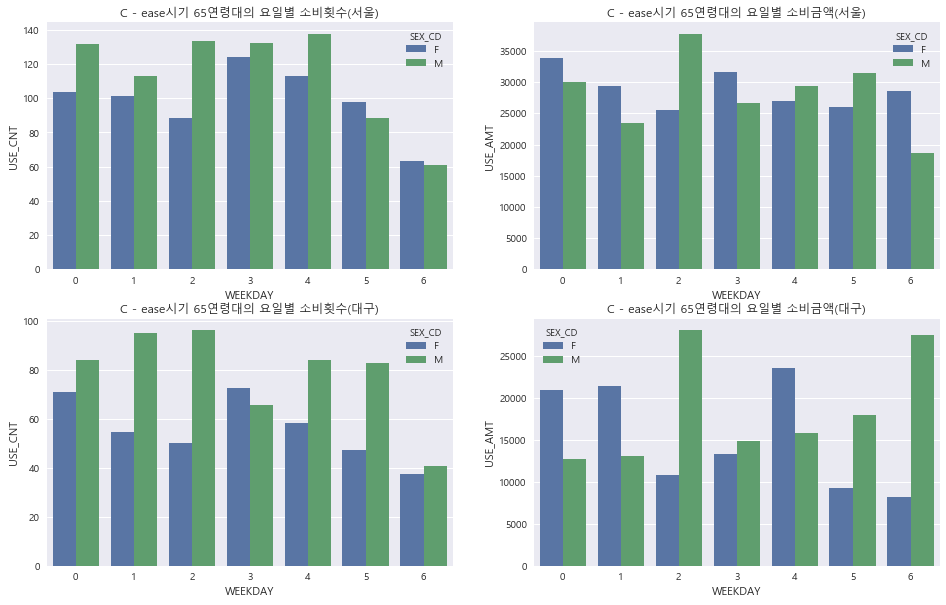

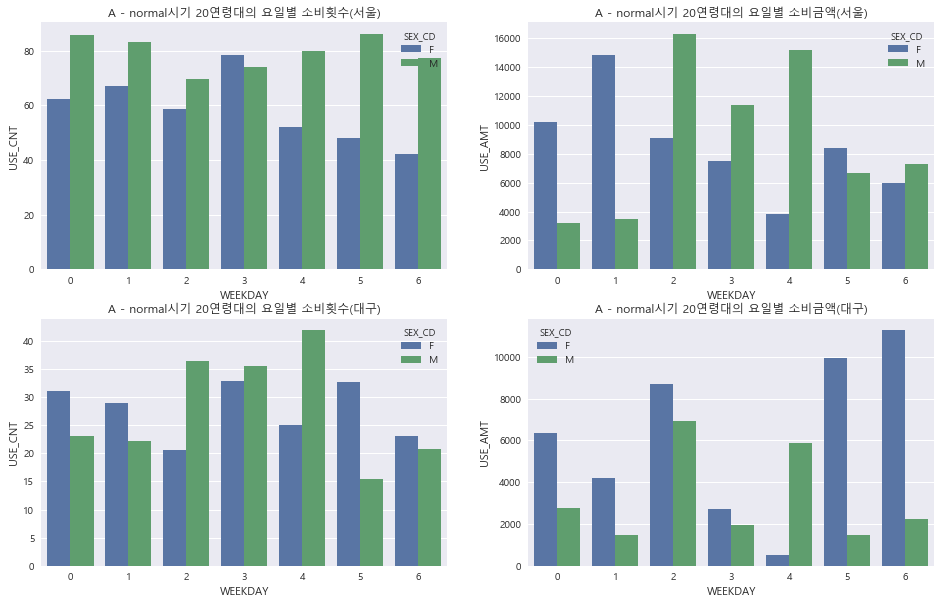

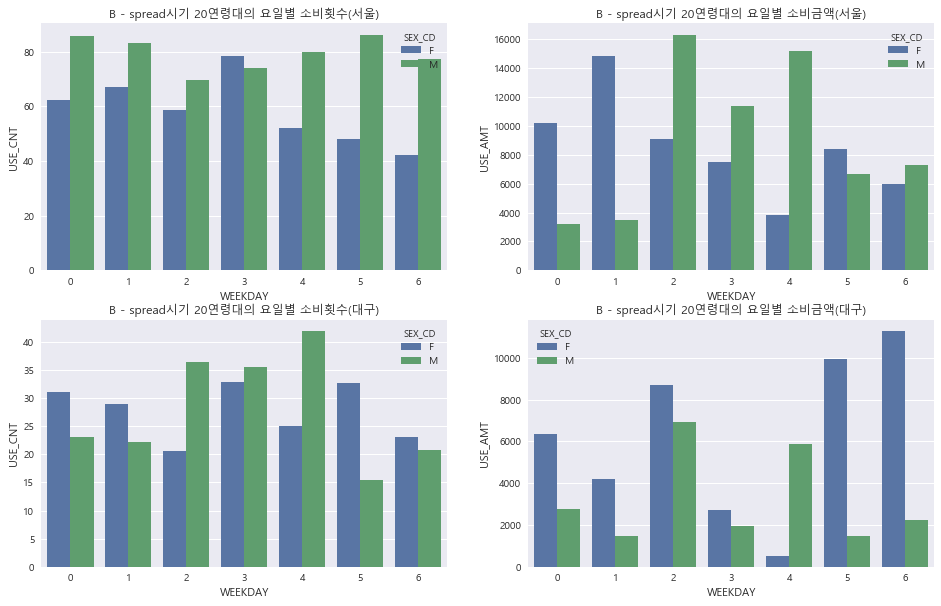

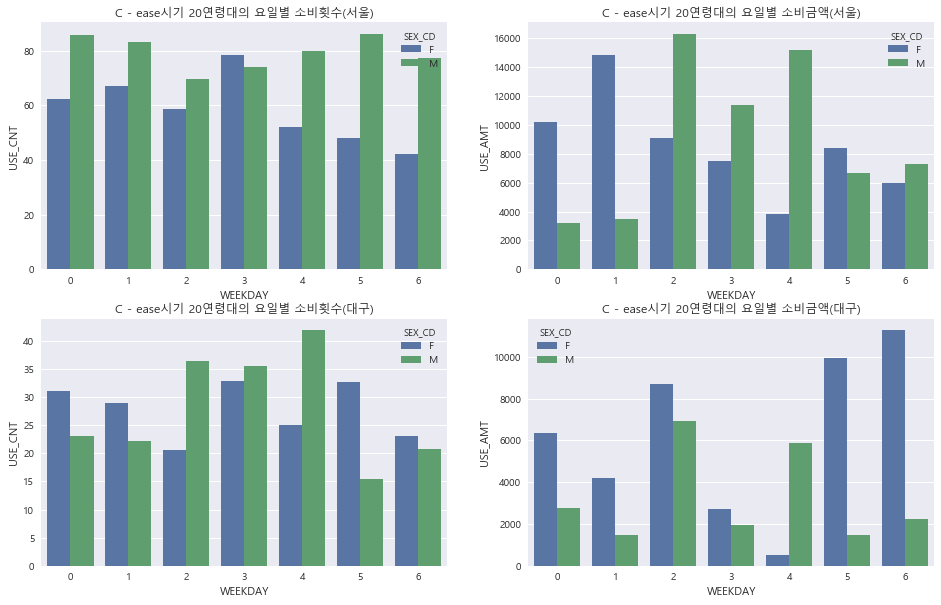

In [41]:
for age in ha['AGE_CD'].unique():
    category_df1 = ha.query('AGE_CD == "{}"'.format(age)).groupby(['SEX_CD','DONG_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
    category_df1 = category_df1.groupby(['SEX_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    category_df2 = haha.query('AGE_CD == "{}"'.format(age)).groupby(['SEX_CD','DONG_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].mean().reset_index()
    category_df2 = category_df2.groupby(['SEX_CD','WEEKDAY'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    
    for peri in ha['PERIOD'].unique():
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
        sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_CNT'], hue='SEX_CD', data=category_df1, ax=axes[0,0])
        sns.barplot(x=category_df1['WEEKDAY'], y=category_df1['USE_AMT'], hue='SEX_CD', data=category_df1, ax=axes[0,1])
        sns.barplot(x=category_df2['WEEKDAY'], y=category_df2['USE_CNT'], hue='SEX_CD', data=category_df2, ax=axes[1,0])
        sns.barplot(x=category_df2['WEEKDAY'], y=category_df2['USE_AMT'], hue='SEX_CD', data=category_df2, ax=axes[1,1])
        axes[0,0].set_title(peri + "시기 {}연령대의 요일별 소비횟수(서울)".format(age))
        axes[0,1].set_title(peri + "시기 {}연령대의 요일별 소비금액(서울)".format(age))
        axes[1,0].set_title(peri + "시기 {}연령대의 요일별 소비횟수(대구)".format(age))
        axes[1,1].set_title(peri + "시기 {}연령대의 요일별 소비금액(대구)".format(age))